**Problem Statement**
Create and train a Plant Identification Machine Learning Model to identify 10’000 plant species using Python. with a goal of 90%+ identification TOP3 accuracy.

Use and follow this study as a starting point: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9551576/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile

In [5]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn
import cv2
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

**Data Preparation**

In [6]:
zip_file_path = '/content/drive/My Drive/datasets/flowers.zip'

In [7]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
  zip_file.extractall('/content/plant_images')

In [8]:
root_dir = r'/content/plant_images/flowers'

In [9]:
X = []
Z = []
IMG_SIZE = 150
daisy_dir = '/content/plant_images/flowers/daisy'
dandelion_dir = '/content/plant_images/flowers/dandelion'
rose_dir = '/content/plant_images/flowers/rose'
sunflower_dir = '/content/plant_images/flowers/sunflower'
tulip_dir = '/content/plant_images/flowers/tulip'

In [10]:
def assign_labels(image,flower_type):
  return flower_type

In [11]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_labels(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        X.append(np.array(img))
        Z.append(str(label))

In [12]:
make_train_data('Daisy',daisy_dir)

100%|██████████| 764/764 [00:01<00:00, 399.47it/s]


In [13]:
make_train_data('Dandelion',dandelion_dir)

100%|██████████| 1052/1052 [00:03<00:00, 308.46it/s]


In [14]:
make_train_data('Rose',rose_dir)

100%|██████████| 784/784 [00:01<00:00, 515.41it/s]


In [15]:
make_train_data('Sunflower',sunflower_dir)

100%|██████████| 733/733 [00:01<00:00, 411.28it/s]


In [16]:
make_train_data('Tulip',tulip_dir)

100%|██████████| 984/984 [00:02<00:00, 458.65it/s]


**Data Visualisation**

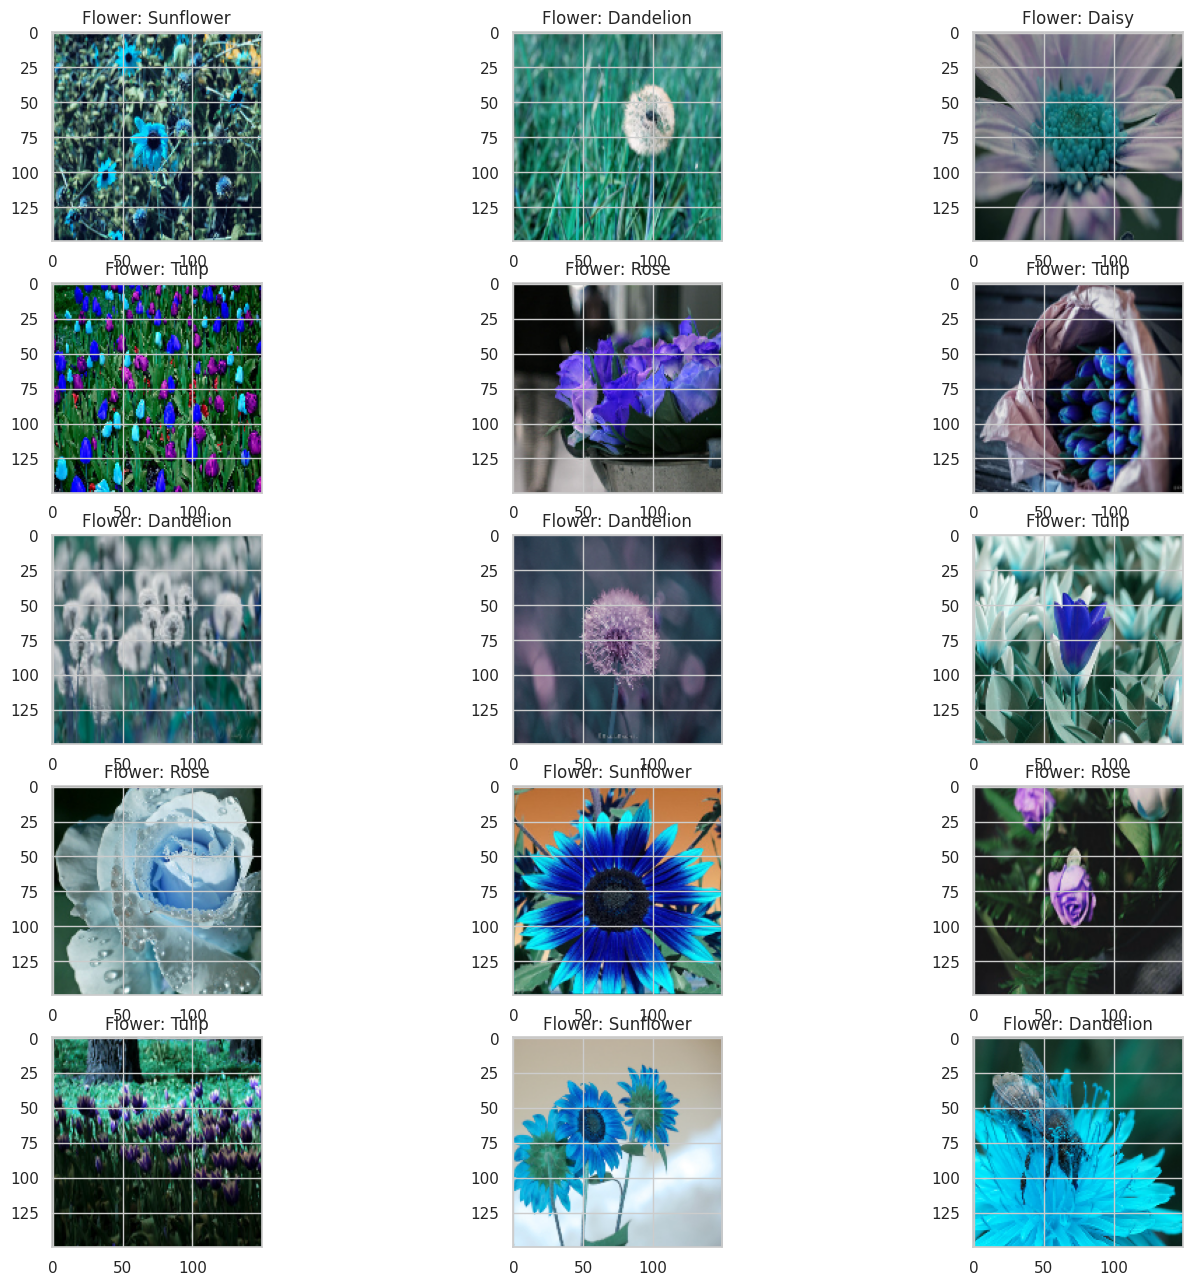

In [17]:
fig,ax = plt.subplots(5,3)
fig.set_size_inches(15,15)
for i in range(5):
  for j in range(3):
    l=rn.randint(0,len(Z))
    ax[i,j].imshow(X[l])
    ax[i,j].set_title("Flower: " + Z[l])

In [18]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [19]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [20]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(1234)

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

**Model Building**

In [22]:
model = Sequential()
model.add(Conv2D(filters = 32,kernel_size = (5,5),padding='same',activation='relu',input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64,kernel_size = (3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 96,kernel_size = (3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 96,kernel_size = (3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [23]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [24]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

In [26]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
25/25 [==============================] - 35s 943ms/step - loss: 1.4209 - accuracy: 0.3728 - val_loss: 1.2327 - val_accuracy: 0.4352
Epoch 2/50
25/25 [==============================] - 19s 781ms/step - loss: 1.1515 - accuracy: 0.5098 - val_loss: 1.0598 - val_accuracy: 0.5556
Epoch 3/50
25/25 [==============================] - 19s 770ms/step - loss: 1.0462 - accuracy: 0.5841 - val_loss: 0.9638 - val_accuracy: 0.6278
Epoch 4/50
25/25 [==============================] - 19s 751ms/step - loss: 0.9811 - accuracy: 0.6069 - val_loss: 0.9067 - val_accuracy: 0.6454
Epoch 5/50
25/25 [==============================] - 20s 817ms/step - loss: 0.9375 - accuracy: 0.6414 - val_loss: 0.9660 - val_accuracy: 0.6222
Epoch 6/50
25/25 [==============================] - 19s 763ms/step - loss: 0.8960 - accuracy: 0.6517 - val_loss: 0.8679 - val_accuracy: 0.6667
Epoch 7/50
25/25 [==============================] - 18s 739ms/step - loss: 0.8385 - accuracy: 0.6703 - val_loss: 0.8609 - val_accuracy: 0.6611

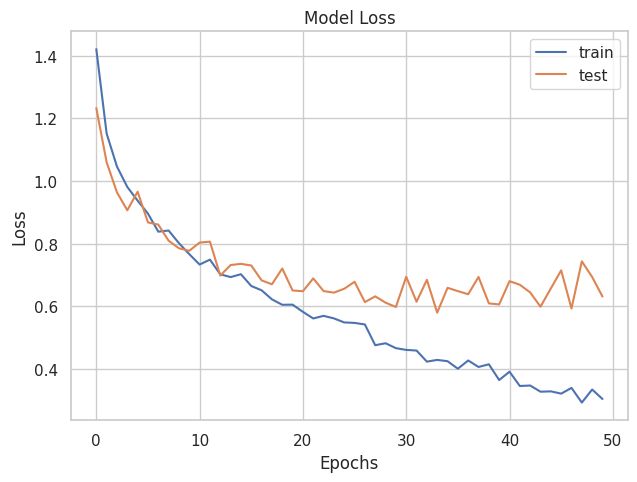

In [27]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

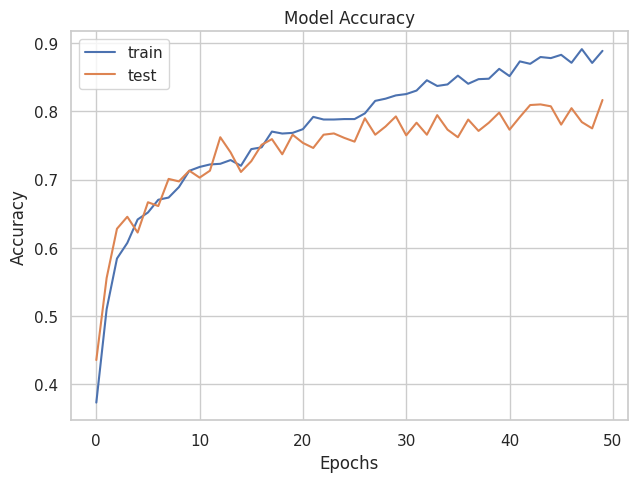

In [30]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()